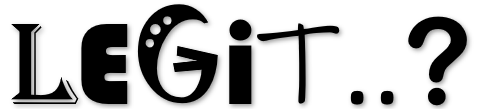

*   This project was started with a goal to simplify the process of analysing a company before applying for an internship/job.
*   This notebook aims to analyse a company based on the user reviews collected from Glassdoor data of RAPID API.
*   GIven the name of the company as user input, the reviews are fetched and then the sentiment is analysed using **TextBlob** and **DistilBERT**.
*   Finally, we help the user decide whether to apply for the company or not based upon the sentiment analysis.

### **Installing the required Packages**

In [25]:
!pip install Textblob
!python -m textblob.download_corpora
!pip install wordcloud

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [26]:
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from IPython.display import Image, display
from wordcloud import WordCloud
from transformers import pipeline

### **Dealing with API**

The below cell fetches the company_id (which in turn is required for fetching the reviews) from the database with company_name as an input. It fetches the ID of first company, hence exact company name is preferred to avoid any false data.

API Key has to be provided to access this code.

In [27]:
def get_company_id(company_name, api_key):
  url = "https://glassdoor-real-time.p.rapidapi.com/companies/auto-complete"

  querystring = {"query":company_name}

  headers = {
    "x-rapidapi-key": api_key,
    "x-rapidapi-host": "glassdoor-real-time.p.rapidapi.com"
  }

  response = requests.get(url, headers=headers, params=querystring)
  data = response.json()

  if data and 'data' in data and len(data['data']) > 0:
    return data['data'][0]['id'], data['data'][0]['logoURL']
  else:
    return None, None

In [28]:
def get_company_reviews(company_id, api_key):
  url = "https://glassdoor-real-time.p.rapidapi.com/companies/reviews"

  querystring = {"companyId":company_id}

  headers = {
    "x-rapidapi-key": api_key,
    "x-rapidapi-host": "glassdoor-real-time.p.rapidapi.com"
  }

  response = requests.get(url, headers=headers, params=querystring)
  data = response.json()

  if data and 'data' in data and 'employerReviewsRG' in data['data'] and 'reviews' in data['data']['employerReviewsRG']:
    reviews_data = data['data']['employerReviewsRG']['reviews']
    reviews_for_sentiment = []
    ratings = []
    for entry in reviews_data:
      review = ' '.join([
          (entry.get('summary') or ''),
          (entry.get('pros') or ''),
          (entry.get('cons') or ''),
          (entry.get('advice') or '')
      ]).strip()
      reviews_for_sentiment.append(review)

      ratings_list = {
            'ratingOverall': entry.get('ratingOverall'),
            'ratingCareerOpportunities': entry.get('ratingCareerOpportunities'),
            'ratingCompensationAndBenefits': entry.get('ratingCompensationAndBenefits'),
            'ratingCultureAndValues': entry.get('ratingCultureAndValues'),
            'ratingWorkLifeBalance': entry.get('ratingWorkLifeBalance'),
        }
      ratings.append(ratings_list)

    return reviews_for_sentiment, ratings
  else:
    return None, None

### **Analysis of fetched Reviews**

### 1.  Using TextBlob

In [29]:
def analyseWithTextBlob(reviews):
  sentiment_scores = []

  for review in reviews:
      blob = TextBlob(review)
      sentiment_scores.append(blob.sentiment.polarity)

  pos=0
  neg=0

  for i in range(len(sentiment_scores)):
    if (sentiment_scores[i]>0):
      pos+=1
    else:
      neg+=1

  if (len(sentiment_scores)>0):
    if (neg/len(sentiment_scores) >= 0.25):
      return 0
    else:
      return 1
  else:
    return 0

After careful analysis, One can realise that Textblob fails to correctly classify mixed reviews i.e., reviews containing both positive and negative words/parts/tokens. So, I ended up using a more powerful model DistilBert after realising both Vader and TextBlob fails in handling mixed reviews.

For more clarity, check out the below example, which clearly is a negative review but TextBlob classifies it as a positive one.

In [30]:
c = TextBlob("Important information for students They can motivate others easily In one sentence, I can say they are totally frauds. I was a mentor for two months. They did not give me a single rupee. When I asked for a salary, they discontinued the class and did not receive my call. So guys, don't believe them. Dont cheat others")
c.sentiment

Sentiment(polarity=0.1904761904761905, subjectivity=0.699404761904762)

### 2. Using Vader

In [31]:
# import nltk
# from nltk.sentiment import SentimentIntensityAnalyzer


# # nltk.download('vader_lexicon')

# sia = SentimentIntensityAnalyzer()

# review = """Important information for students They can motivate others easily In one sentence, I can say they are totally frauds. I was a mentor for two months. They did not give me a single rupee. When I asked for a salary, they discontinued the class and did not receive my call. So guys, don't believe them. Dont cheat others"""
# score = sia.polarity_scores(review)
# print(score)

### 3. Using DistilBert

In [32]:
def analyseWithBert(reviews):
  sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", truncation=True)
  results = sentiment_pipeline(reviews)

  neg=0
  for review, result in zip(reviews, results):
      if (result['label'] == 'NEGATIVE'):
        neg+=1

  if (len(reviews)>0):
    if (neg/len(reviews) >= 0.30):
      return 0
    else:
      return 1
  else:
    return 0

### Using frequently used Keywords to analyse

In [33]:
def matchWithWords(reviews):
  keywords = [
      "scam", "scams", "scammer", "scammers", "scamming",
      "don't join", "dont join", "toxic", "fraud", "frauds"
  ]

  matching_reviews = [
      review for review in reviews
      if any(keyword in review.lower() for keyword in keywords)
  ]

  if (len(reviews)>0):
    percentage = len(matching_reviews) / len(reviews)
  else:
    percentage = 0

  if percentage >= 0.25:
      return 0
  return 1

In [34]:
def generate_wordcloud(reviews):
  combinedReviews = ' '.join(reviews)
  combinedReviews = combinedReviews.replace('\r\n', ' ').replace('\n', ' ').replace('\r', ' ')

  blob = TextBlob(combinedReviews)
  noun_words = ' '.join(word for (word, tag) in blob.tags if tag.startswith('NN'))

  wordcloud = WordCloud(width=700, height=400, background_color='white', collocations=False).generate(noun_words)

  plt.figure(figsize=(15, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [ ]:
RAPID_API_KEY = "Enter your RAPID API KEY"

In [39]:
def analyse(company_name):
  company_id, company_logo = get_company_id(company_name, RAPID_API_KEY)

  if company_id:
    print(f"Company ID: {company_id}")
    print("Company Logo:")
    if (company_logo): display(Image(url = company_logo))
    else: print("No logo found")

    reviews, ratings = get_company_reviews(company_id, RAPID_API_KEY)

    if reviews:
      way1 = analyseWithTextBlob(reviews)
      way2 = analyseWithBert(reviews)
      way3 = matchWithWords(reviews)
      generate_wordcloud(reviews)

      print("-"*50)
      if (way1 and way2 and way3):
        print(f'You can apply to {company_name}')
      else:
        print(f'Not Recommended!!! Join at your own risk')
      print("-"*50)
    else:
      print(f"No reviews found for '{company_name}'. Cannot perform analysis.")

  else:
    print(f"Could not find company information for '{company_name}'.")

The criteria we used here is :  
If more than 30% or the reviews are marked Negative by the model, we won't recommend the company.  
Also, if more than 25% of the reviews contain any matching pre-defined keywords such as 'fraud', 'scam'... , we directly reject the company.

Here, 4 companies were displayed Flipkart, Prodigy Infotech, Codesoft, Codegnan where Flipkart is a legit company and the other 3 companies were reported to be offering fake internships to the students.

Enter name of the company: Flipkart
Company ID: 300494
Company Logo:


Device set to use cpu


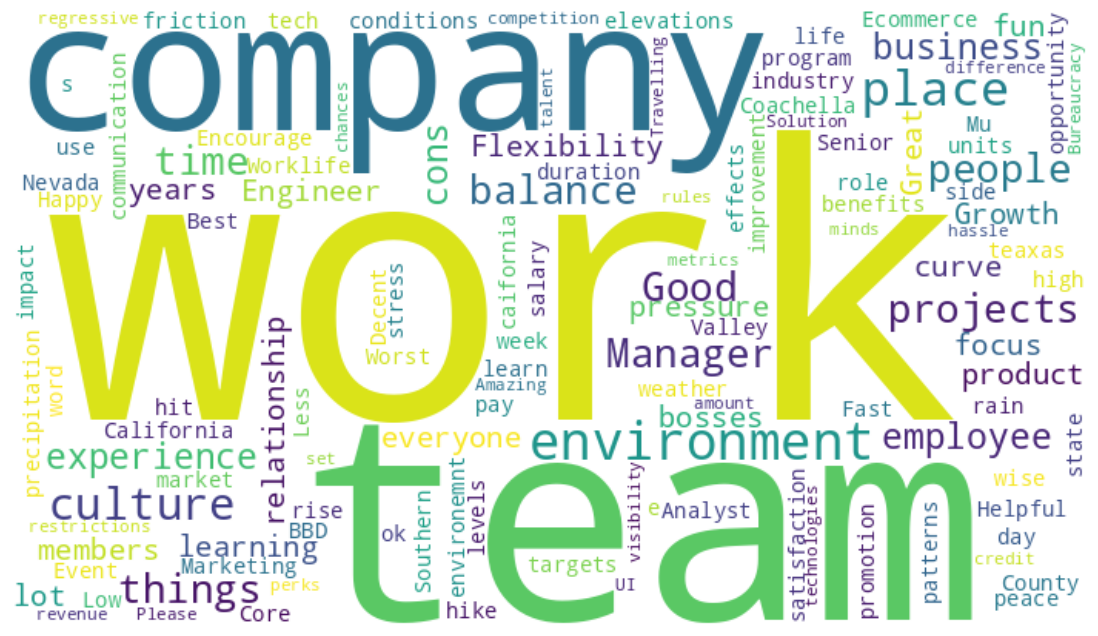

--------------------------------------------------
You can apply to Flipkart
--------------------------------------------------


In [41]:
company_name = input("Enter name of the company: ")
analyse(company_name)

Enter name of the company: Prodigy Infotech
Company ID: 443968
Company Logo:
No logo found


Device set to use cpu


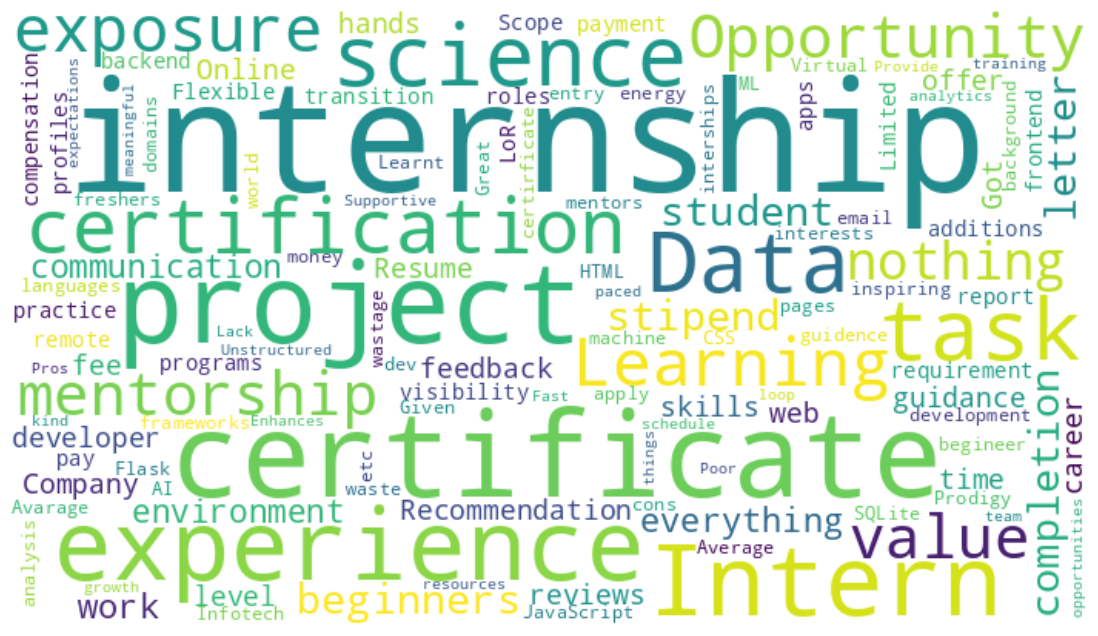

--------------------------------------------------
Not Recommended!!! Join at your own risk
--------------------------------------------------


In [42]:
company_name = input("Enter name of the company: ")
analyse(company_name)

Enter name of the company: Codesoft
Company ID: 262521
Company Logo:


Device set to use cpu


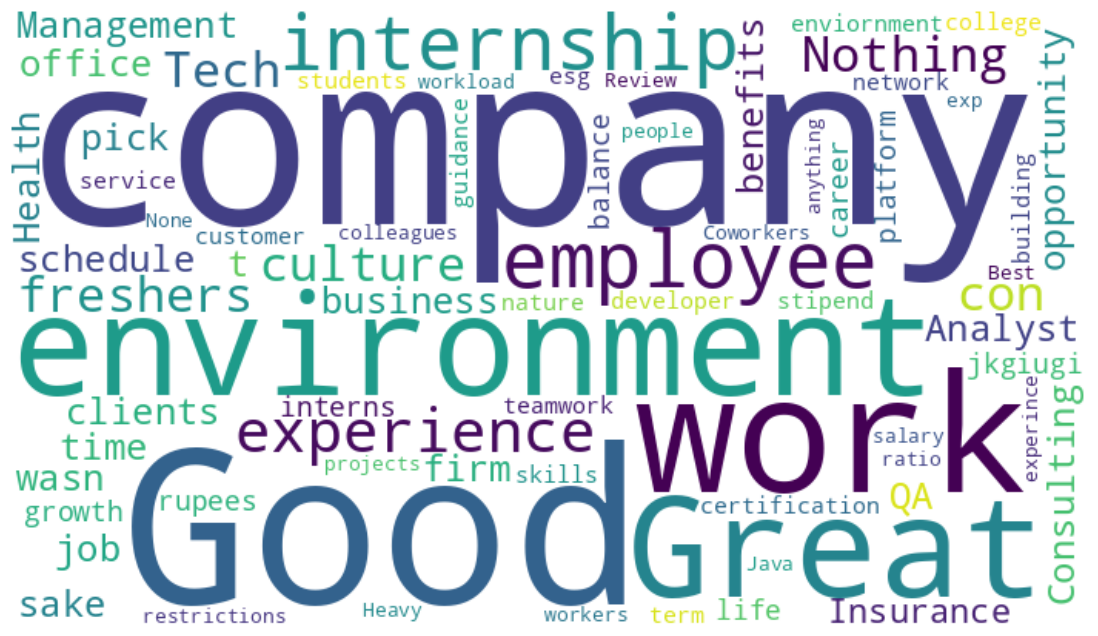

--------------------------------------------------
Not Recommended!!! Join at your own risk
--------------------------------------------------


In [43]:
company_name = input("Enter name of the company: ")
analyse(company_name)

Enter name of the company: Codegnan
Company ID: 3882280
Company Logo:


Device set to use cpu


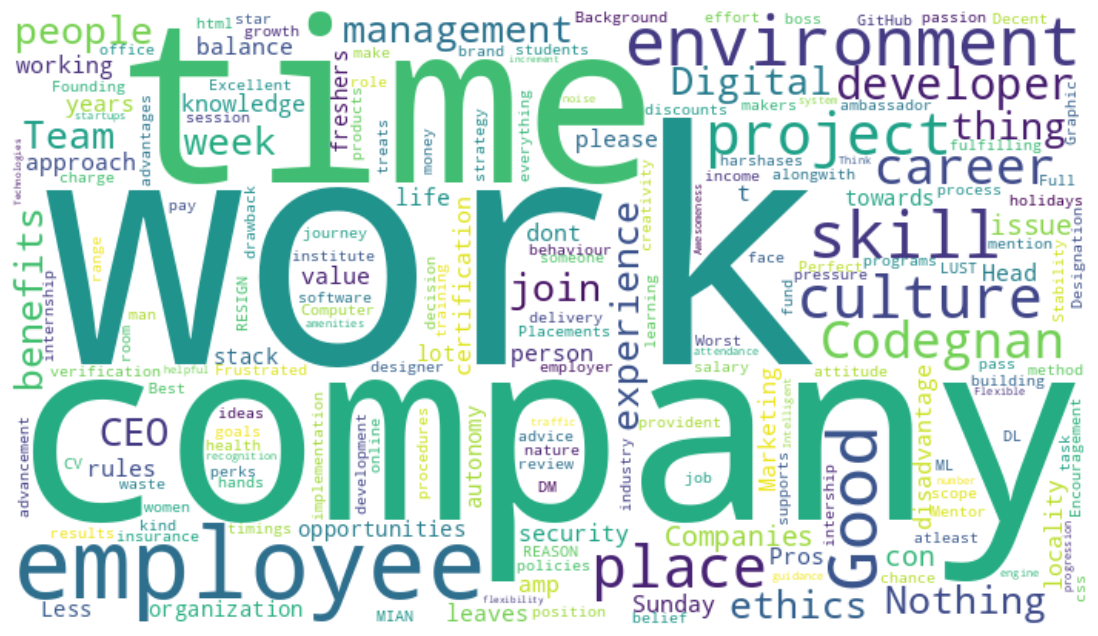

--------------------------------------------------
Not Recommended!!! Join at your own risk
--------------------------------------------------


In [44]:
company_name = input("Enter name of the company: ")
analyse(company_name)